In [ ]:
!pip install transformers
!pip install diffusers
!pip install folium==0.9.1
!pip install huggingface-hub
!pip install pillow==9.0.0
!pip install scikit-image==0.19.2
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 17.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.3/716.3 KB 11.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 KB 4.1 MB/s eta 0:00:00
  Attempting uninstall: folium
    Found existing installation: folium 0.12.1.post1
    Uninstalling folium-0.12.1.post1:
      Successfully uninstalled folium-0.12.1.post1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pyp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 90.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 6.3 MB/s eta 0:00:00


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
"""
    modified based on diffusion library from Huggingface: https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py
"""
import inspect
import warnings
from typing import Callable, List, Optional, Union

import torch
import PIL
import numpy as np

from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
from packaging import version
from diffusers.models import AutoencoderKL, UNet2DConditionModel
from diffusers.pipeline_utils import DiffusionPipeline
from diffusers.schedulers import (
    DDIMScheduler,
    DDPMScheduler,
    DPMSolverMultistepScheduler,
    EulerAncestralDiscreteScheduler,
    EulerDiscreteScheduler,
    LMSDiscreteScheduler,
    PNDMScheduler,
)
from diffusers.utils import BaseOutput
from dataclasses import dataclass
from torch.nn.functional import interpolate

@dataclass
class StableDiffusionPipelineOutput(BaseOutput):
    """
    Output class for Stable Diffusion pipelines.
    Args:
        images (`List[PIL.Image.Image]` or `np.ndarray`)
            List of denoised PIL images of length `batch_size` or numpy array of shape `(batch_size, height, width,
            num_channels)`. PIL images or numpy array present the denoised images of the diffusion pipeline.
        nsfw_content_detected (`List[bool]`)
            List of flags denoting whether the corresponding generated image likely represents "not-safe-for-work"
            (nsfw) content.
    """

    images: Union[List[PIL.Image.Image], np.ndarray]
    nsfw_content_detected: List[bool]

class TapistryStableDiffusionPipeline(DiffusionPipeline):
    r"""
    Pipeline for text-to-image generation using Stable Diffusion.

    This model inherits from [`DiffusionPipeline`]. Check the superclass documentation for the generic methods the
    library implements for all the pipelines (such as downloading or saving, running on a particular device, etc.)

    Args:
        vae ([`AutoencoderKL`]):
            Variational Auto-Encoder (VAE) Model to encode and decode images to and from latent representations.
        text_encoder ([`CLIPTextModel`]):
            Frozen text-encoder. Stable Diffusion uses the text portion of
            [CLIP](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel), specifically
            the [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14) variant.
        tokenizer (`CLIPTokenizer`):
            Tokenizer of class
            [CLIPTokenizer](https://huggingface.co/docs/transformers/v4.21.0/en/model_doc/clip#transformers.CLIPTokenizer).
        unet ([`UNet2DConditionModel`]): Conditional U-Net architecture to denoise the encoded image latents.
        scheduler ([`SchedulerMixin`]):
            A scheduler to be used in combination with `unet` to denoise the encoded image latents. Can be one of
            [`DDIMScheduler`], [`LMSDiscreteScheduler`], or [`PNDMScheduler`].
        safety_checker ([`StableDiffusionSafetyChecker`]):
            Classification module that estimates whether generated images could be considered offensive or harmful.
            Please, refer to the [model card](https://huggingface.co/runwayml/stable-diffusion-v1-5) for details.
        feature_extractor ([`CLIPFeatureExtractor`]):
            Model that extracts features from generated images to be used as inputs for the `safety_checker`.
    """
    _optional_components = ["safety_checker", "feature_extractor"]

    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: Union[
            DDIMScheduler,
            PNDMScheduler,
            LMSDiscreteScheduler,
            EulerDiscreteScheduler,
            EulerAncestralDiscreteScheduler,
            DPMSolverMultistepScheduler,
        ],
        safety_checker: None,
        feature_extractor: CLIPFeatureExtractor,
        requires_safety_checker: bool = True,
    ):
        super().__init__()

        if hasattr(scheduler.config, "steps_offset") and scheduler.config.steps_offset != 1:
            deprecation_message = (
                f"The configuration file of this scheduler: {scheduler} is outdated. `steps_offset`"
                f" should be set to 1 instead of {scheduler.config.steps_offset}. Please make sure "
                "to update the config accordingly as leaving `steps_offset` might led to incorrect results"
                " in future versions. If you have downloaded this checkpoint from the Hugging Face Hub,"
                " it would be very nice if you could open a Pull request for the `scheduler/scheduler_config.json`"
                " file"
            )
            deprecate("steps_offset!=1", "1.0.0", deprecation_message, standard_warn=False)
            new_config = dict(scheduler.config)
            new_config["steps_offset"] = 1
            scheduler._internal_dict = FrozenDict(new_config)

        if hasattr(scheduler.config, "clip_sample") and scheduler.config.clip_sample is True:
            deprecation_message = (
                f"The configuration file of this scheduler: {scheduler} has not set the configuration `clip_sample`."
                " `clip_sample` should be set to False in the configuration file. Please make sure to update the"
                " config accordingly as not setting `clip_sample` in the config might lead to incorrect results in"
                " future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very"
                " nice if you could open a Pull request for the `scheduler/scheduler_config.json` file"
            )
            deprecate("clip_sample not set", "1.0.0", deprecation_message, standard_warn=False)
            new_config = dict(scheduler.config)
            new_config["clip_sample"] = False
            scheduler._internal_dict = FrozenDict(new_config)

        if safety_checker is None and requires_safety_checker:
            logger.warning(
                f"You have disabled the safety checker for {self.__class__} by passing `safety_checker=None`. Ensure"
                " that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered"
                " results in services or applications open to the public. Both the diffusers team and Hugging Face"
                " strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling"
                " it only for use-cases that involve analyzing network behavior or auditing its results. For more"
                " information, please have a look at https://github.com/huggingface/diffusers/pull/254 ."
            )

        if safety_checker is not None and feature_extractor is None:
            raise ValueError(
                "Make sure to define a feature extractor when loading {self.__class__} if you want to use the safety"
                " checker. If you do not want to use the safety checker, you can pass `'safety_checker=None'` instead."
            )

        is_unet_version_less_0_9_0 = hasattr(unet.config, "_diffusers_version") and version.parse(
            version.parse(unet.config._diffusers_version).base_version
        ) < version.parse("0.9.0.dev0")
        is_unet_sample_size_less_64 = hasattr(unet.config, "sample_size") and unet.config.sample_size < 64
        if is_unet_version_less_0_9_0 and is_unet_sample_size_less_64:
            deprecation_message = (
                "The configuration file of the unet has set the default `sample_size` to smaller than"
                " 64 which seems highly unlikely. If your checkpoint is a fine-tuned version of any of the"
                " following: \n- CompVis/stable-diffusion-v1-4 \n- CompVis/stable-diffusion-v1-3 \n-"
                " CompVis/stable-diffusion-v1-2 \n- CompVis/stable-diffusion-v1-1 \n- runwayml/stable-diffusion-v1-5"
                " \n- runwayml/stable-diffusion-inpainting \n you should change 'sample_size' to 64 in the"
                " configuration file. Please make sure to update the config accordingly as leaving `sample_size=32`"
                " in the config might lead to incorrect results in future versions. If you have downloaded this"
                " checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for"
                " the `unet/config.json` file"
            )
            deprecate("sample_size<64", "1.0.0", deprecation_message, standard_warn=False)
            new_config = dict(unet.config)
            new_config["sample_size"] = 64
            unet._internal_dict = FrozenDict(new_config)

        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
        )
        self.vae_scale_factor = 2 ** (len(self.vae.config.block_out_channels) - 1)
        self.register_to_config(requires_safety_checker=requires_safety_checker)

    def enable_vae_slicing(self):
        r"""
        Enable sliced VAE decoding.

        When this option is enabled, the VAE will split the input tensor in slices to compute decoding in several
        steps. This is useful to save some memory and allow larger batch sizes.
        """
        self.vae.enable_slicing()

    def disable_vae_slicing(self):
        r"""
        Disable sliced VAE decoding. If `enable_vae_slicing` was previously invoked, this method will go back to
        computing decoding in one step.
        """
        self.vae.disable_slicing()

    def enable_sequential_cpu_offload(self, gpu_id=0):
        r"""
        Offloads all models to CPU using accelerate, significantly reducing memory usage. When called, unet,
        text_encoder, vae and safety checker have their state dicts saved to CPU and then are moved to a
        `torch.device('meta') and loaded to GPU only when their specific submodule has its `forward` method called.
        """
        if is_accelerate_available():
            from accelerate import cpu_offload
        else:
            raise ImportError("Please install accelerate via `pip install accelerate`")

        device = torch.device(f"cuda:{gpu_id}")

        for cpu_offloaded_model in [self.unet, self.text_encoder, self.vae]:
            if cpu_offloaded_model is not None:
                cpu_offload(cpu_offloaded_model, device)

        if self.safety_checker is not None:
            # TODO(Patrick) - there is currently a bug with cpu offload of nn.Parameter in accelerate
            # fix by only offloading self.safety_checker for now
            cpu_offload(self.safety_checker.vision_model, device)

    @property
    def _execution_device(self):
        r"""
        Returns the device on which the pipeline's models will be executed. After calling
        `pipeline.enable_sequential_cpu_offload()` the execution device can only be inferred from Accelerate's module
        hooks.
        """
        if self.device != torch.device("meta") or not hasattr(self.unet, "_hf_hook"):
            return self.device
        for module in self.unet.modules():
            if (
                hasattr(module, "_hf_hook")
                and hasattr(module._hf_hook, "execution_device")
                and module._hf_hook.execution_device is not None
            ):
                return torch.device(module._hf_hook.execution_device)
        return self.device

    def _encode_prompt(self, prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt):
        r"""
        Encodes the prompt into text encoder hidden states.

        Args:
            prompt (`str` or `list(int)`):
                prompt to be encoded
            device: (`torch.device`):
                torch device
            num_images_per_prompt (`int`):
                number of images that should be generated per prompt
            do_classifier_free_guidance (`bool`):
                whether to use classifier free guidance or not
            negative_prompt (`str` or `List[str]`):
                The prompt or prompts not to guide the image generation. Ignored when not using guidance (i.e., ignored
                if `guidance_scale` is less than `1`).
        """
        batch_size = len(prompt) if isinstance(prompt, list) else 1

        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids
        untruncated_ids = self.tokenizer(prompt, padding="longest", return_tensors="pt").input_ids

        if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(text_input_ids, untruncated_ids):
            removed_text = self.tokenizer.batch_decode(untruncated_ids[:, self.tokenizer.model_max_length - 1 : -1])
            logger.warning(
                "The following part of your input was truncated because CLIP can only handle sequences up to"
                f" {self.tokenizer.model_max_length} tokens: {removed_text}"
            )

        if hasattr(self.text_encoder.config, "use_attention_mask") and self.text_encoder.config.use_attention_mask:
            attention_mask = text_inputs.attention_mask.to(device)
        else:
            attention_mask = None

        text_embeddings = self.text_encoder(
            text_input_ids.to(device),
            attention_mask=attention_mask,
        )
        text_embeddings = text_embeddings[0]

        # duplicate text embeddings for each generation per prompt, using mps friendly method
        bs_embed, seq_len, _ = text_embeddings.shape
        text_embeddings = text_embeddings.repeat(1, num_images_per_prompt, 1)
        text_embeddings = text_embeddings.view(bs_embed * num_images_per_prompt, seq_len, -1)

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            uncond_tokens: List[str]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif type(prompt) is not type(negative_prompt):
                raise TypeError(
                    f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                    f" {type(prompt)}."
                )
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            elif batch_size != len(negative_prompt):
                raise ValueError(
                    f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                    f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                    " the batch size of `prompt`."
                )
            else:
                uncond_tokens = negative_prompt

            max_length = text_input_ids.shape[-1]
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="pt",
            )

            if hasattr(self.text_encoder.config, "use_attention_mask") and self.text_encoder.config.use_attention_mask:
                attention_mask = uncond_input.attention_mask.to(device)
            else:
                attention_mask = None

            uncond_embeddings = self.text_encoder(
                uncond_input.input_ids.to(device),
                attention_mask=attention_mask,
            )
            uncond_embeddings = uncond_embeddings[0]

            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = uncond_embeddings.shape[1]
            uncond_embeddings = uncond_embeddings.repeat(1, num_images_per_prompt, 1)
            uncond_embeddings = uncond_embeddings.view(batch_size * num_images_per_prompt, seq_len, -1)

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        return text_embeddings

    def run_safety_checker(self, image, device, dtype):
        if self.safety_checker is not None:
            safety_checker_input = self.feature_extractor(self.numpy_to_pil(image), return_tensors="pt").to(device)
            image, has_nsfw_concept = self.safety_checker(
                images=image, clip_input=safety_checker_input.pixel_values.to(dtype)
            )
        else:
            has_nsfw_concept = None
        return image, has_nsfw_concept

    def decode_latents(self, latents):
        latents = 1 / 0.18215 * latents
        image = self.vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        # we always cast to float32 as this does not cause significant overhead and is compatible with bfloa16
        image = image.cpu().permute(0, 2, 3, 1).float().numpy()
        return image

    def prepare_extra_step_kwargs(self, generator, eta):
        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]

        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        # check if the scheduler accepts generator
        accepts_generator = "generator" in set(inspect.signature(self.scheduler.step).parameters.keys())
        if accepts_generator:
            extra_step_kwargs["generator"] = generator
        return extra_step_kwargs

    def check_inputs(self, prompt, height, width, callback_steps):
        if not isinstance(prompt, str) and not isinstance(prompt, list):
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        if height % 8 != 0 or width % 8 != 0:
            raise ValueError(f"`height` and `width` have to be divisible by 8 but are {height} and {width}.")

        if (callback_steps is None) or (
            callback_steps is not None and (not isinstance(callback_steps, int) or callback_steps <= 0)
        ):
            raise ValueError(
                f"`callback_steps` has to be a positive integer but is {callback_steps} of type"
                f" {type(callback_steps)}."
            )

    def prepare_latents(self, batch_size, num_channels_latents, height, width, dtype, device, generator, latents=None):
        shape = (batch_size, num_channels_latents, height // self.vae_scale_factor, width // self.vae_scale_factor)
        if latents is None:
            if device.type == "mps":
                # randn does not work reproducibly on mps
                latents = torch.randn(shape, generator=generator, device="cpu", dtype=dtype).to(device)
            else:
                latents = torch.randn(shape, generator=generator, device=device, dtype=dtype)
        else:
            if latents.shape != shape:
                raise ValueError(f"Unexpected latents shape, got {latents.shape}, expected {shape}")
            latents = latents.to(device)

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma
        return latents

    @torch.no_grad()
    def __call__(
        self,
        context,
        sampler,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[torch.Generator] = None,
        latents: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: Optional[int] = 1,
    ):
        r"""
        Function invoked when calling the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`):
                The prompt or prompts to guide the image generation.
            height (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The height in pixels of the generated image.
            width (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The width in pixels of the generated image.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. Ignored when not using guidance (i.e., ignored
                if `guidance_scale` is less than `1`).
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [`schedulers.DDIMScheduler`], will be ignored for others.
            generator (`torch.Generator`, *optional*):
                A [torch generator](https://pytorch.org/docs/stable/generated/torch.Generator.html) to make generation
                deterministic.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
                plain tuple.
            callback (`Callable`, *optional*):
                A function that will be called every `callback_steps` steps during inference. The function will be
                called with the following arguments: `callback(step: int, timestep: int, latents: torch.FloatTensor)`.
            callback_steps (`int`, *optional*, defaults to 1):
                The frequency at which the `callback` function will be called. If not specified, the callback will be
                called at every step.

        Returns:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] or `tuple`:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] if `return_dict` is True, otherwise a `tuple.
            When returning a tuple, the first element is a list with the generated images, and the second element is a
            list of `bool`s denoting whether the corresponding generated image likely represents "not-safe-for-work"
            (nsfw) content, according to the `safety_checker`.
        """
        # 0. Default height and width to unet
        height = height or self.unet.config.sample_size * self.vae_scale_factor
        width = width or self.unet.config.sample_size * self.vae_scale_factor

        # 1. Check inputs. Raise error if not correct
        # self.check_inputs(prompt, height, width, callback_steps)

        # 2. Define call parameters

        prompts = []
        weights = []
        sizes = []

        for k, v in context.items():
          size, start_x, start_y = k
          prompt = v['string']
          guidance = v['magnitude']

          prompts.append(prompt)
          weights.append(guidance)
          sizes.append([size, start_x, start_y])

        prompt = prompts

        # batch_size = 1 if isinstance(prompt, str) else len(prompt)
        device = self._execution_device

        weights = torch.Tensor(weights).to(device)[:, None, None, None]
        do_classifier_free_guidance = True


        # 3. Encode input prompt
        text_embeddings = self._encode_prompt(
            prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
        )

        # 4. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = self.scheduler.timesteps

        # 5. Prepare latent variables
        num_channels_latents = self.unet.in_channels

        latents_canvas = self.prepare_latents(
            1,
            num_channels_latents,
            height,
            width,
            text_embeddings.dtype,
            device,
            generator,
            latents,
        )

        _, _, canvas_size, _ = latents_canvas.size()

        latents = extract_latents(latents_canvas, sizes)
        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order

        alphas = 1 - self.scheduler.betas
        alphas_cumprod = np.cumprod(alphas)
        scalar = np.sqrt(1 / (1 - alphas_cumprod))

        # Compute the gradient function for MCMC sampling
        def gradient_fn(x, t, text_embeddings):

          # Compute normal classifier-free guidance update
          latent_model_input = torch.cat([x] * 2)
          noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

          s = noise_pred.size()
          noise_pred = noise_pred.reshape(2, -1, *s[1:])
          noise_pred_uncond, noise_pred_text = noise_pred[0], noise_pred[1]
          noise_pred = noise_pred_uncond + (weights * (noise_pred_text - noise_pred_uncond))

          # make gradient update consistent across canvas
          noise_pred_canvas = make_canvas(noise_pred, canvas_size, sizes)
          noise_pred = extract_latents(noise_pred_canvas, sizes)

          # Need to scale the gradients by coefficient to properly account for normalization in DSM loss + data contraction
          scale = scalar[t]

          return -1 * scale * noise_pred

        def sync_fn(x):
          x_canvas = make_canvas(x, canvas_size, sizes)
          x = extract_latents(x_canvas, sizes)

          return x

        def noise_fn():
          noise_canvas = torch.randn_like(latents_canvas)
          noise = extract_latents(noise_canvas, sizes)

          return noise

        sampler._gradient_function = gradient_fn
        sampler._sync_function = sync_fn
        sampler._noise_function = noise_fn

        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

                # perform guidance
                if do_classifier_free_guidance:
                    s = noise_pred.size()
                    noise_pred = noise_pred.reshape(2, -1, *s[1:])
                    noise_pred_uncond, noise_pred_text = noise_pred[0], noise_pred[1]
                    noise_pred = noise_pred_uncond + (weights * (noise_pred_text - noise_pred_uncond))

                # transition from one noisy distribution to the next one x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

                latents = sync_fn(latents)

                if t > 50:
                  # The score functions in the last 50 steps don't really change the image
                  latents = sampler.sample_step(latents, t, text_embeddings)

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        callback(i, t, latents)

        latents_panel = make_canvas(latents, canvas_size, sizes)
        # 8. Post-processing

        return latents_panel

In [ ]:
# Code for take individual latents grids and making them into a 2D canvas from a set of conditioned text instructions

def extract_latents(latent_canvas, sizes):
  # Extract different latent chunks from a canvas
  latents = []

  for size in sizes:
    sf, x_start, y_start = size
    width = sf * 64
    latent = latent_canvas[:, :, y_start:y_start+width, x_start:x_start+width]

    if sf == 1:
      latent = latent
    elif sf == 2:
      latent = interpolate(latent, (64, 64), mode='nearest')

    latents.append(latent)

  latents = torch.cat(latents, dim=0)
  return latents


def make_canvas(latents, canvas_size, sizes):
  # Make a canvas from different latents
  canvas_count = torch.zeros(canvas_size, canvas_size).to(latents.device)
  canvas_latent = torch.zeros(1, 4, canvas_size, canvas_size).to(latents.device)

  for size, latent in zip(sizes, latents):
    latent = latent[None]
    sf, x_start, y_start = size
    size = 64 * sf
    latent_expand = interpolate(latent, (size, size), mode='nearest')

    weight = 1 / (sf ** 2)

    canvas_latent[:, :, y_start:y_start+size, x_start:x_start+size] = weight * latent_expand + canvas_latent[:, :, y_start:y_start+size, x_start:x_start+size]
    canvas_count[y_start:y_start+size, x_start:x_start+size] =  canvas_count[y_start:y_start+size, x_start:x_start+size] + weight

  canvas_latent = canvas_latent / (canvas_count[None, None] + 1e-5)

  return canvas_latent

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# **MCMC Sampling to Generate Tapestries**

Below is the code for different samplers

In [ ]:
# Code for Samplers
import torch

class AnnealedULASampler:
  """Implements AIS with ULA"""

  def __init__(self,
               num_steps,
               num_samples_per_step,
               step_sizes,
               gradient_function,
               sync_function,
               noise_function):
    assert len(step_sizes) == num_steps, "Must have as many stepsizes as intermediate distributions."
    self._step_sizes = step_sizes
    self._num_steps = num_steps
    self._num_samples_per_step = num_samples_per_step
    self._gradient_function = gradient_function
    self._sync_function = sync_function
    self._noise_function = noise_function

  def sample_step(self, x, t, text_embeddings):

    for i in range(self._num_samples_per_step):
      ss = self._step_sizes[t]
      std = (2 * ss) ** .5
      grad = self._gradient_function(x, t, text_embeddings)
      noise = self._noise_function() * std
      x = x + grad * ss + noise

    return x



class AnnealedUHASampler:
  """Implements UHA Sampling"""

  def __init__(self,
               num_steps,
               num_samples_per_step,
               step_sizes,
               damping_coeff,
               mass_diag_sqrt,
               num_leapfrog_steps,
               gradient_function,
               sync_function):
    assert len(step_sizes) == num_steps, "Must have as many stepsizes as intermediate distributions."
    self._damping_coeff = damping_coeff
    self._mass_diag_sqrt = mass_diag_sqrt
    self._step_sizes = step_sizes
    self._num_steps = num_steps
    self._num_leapfrog_steps = num_leapfrog_steps
    self._num_samples_per_step = num_samples_per_step
    self._gradient_function = gradient_function
    self._sync_function = sync_function

  def leapfrog_step(self, x, v, i, text_embeddings):
      step_size = self._step_sizes[i]
      return leapfrog_step(x, v, lambda _x: self._gradient_function(_x, i, text_embeddings), step_size, self._mass_diag_sqrt[i], self._num_leapfrog_steps)


  def sample_step(self, x, t, text_embeddings):

    # Sample Momentum
    v = torch.randn_like(x) * self._mass_diag_sqrt[t]
    v = self._sync_function(v)

    for i in range(self._num_samples_per_step):

      # Partial Momentum Refreshment
      eps = torch.randn_like(x)
      eps = self._sync_function(eps)

      v = v * self._damping_coeff + np.sqrt(1. - self._damping_coeff**2) * eps * self._mass_diag_sqrt[t]

      x, v = self.leapfrog_step(x, v, t, text_embeddings)

    return x

In [ ]:
def clip(val, max_val):
  return min(max(val, 0), max_val)

def pad(val, padding, max):
  val_min = clip(val - padding, max)
  val_max = clip(val + padding, max)

  return val_min, val_max

def draw_box(img, start, size, color, max_size):
  padding = 5
  H, W, _ = img.shape

  xmin, ymin = start

  xmax = xmin + size
  ymax = ymin + size

  xmin_lower, xmin_upper = pad(xmin, padding, max_size)
  xmax_lower, xmax_upper = pad(xmax, padding, max_size)
  ymin_lower, ymin_upper = pad(ymin, padding, max_size)
  ymax_lower, ymax_upper = pad(ymax, padding, max_size)

  # Draw each portion of an image
  img[ymin_lower:ymin_upper, xmin:xmax] = np.array(color)[None, None, :]
  img[ymax_lower:ymax_upper, xmin:xmax] = np.array(color)[None, None, :]
  img[ymin:ymax, xmin_lower:xmin_upper] = np.array(color)[None, None, :]
  img[ymin:ymax, xmax_lower:xmax_upper] = np.array(color)[None, None, :]


def visualize_context(canvas_size, base_size, context, color_lookup):
  img = np.zeros([canvas_size,canvas_size,3])

  for k, v in context.items():
    scale, xstart, ystart = k
    caption = v['string']
    color = color_lookup[caption][0]
    draw_box(img, (xstart, ystart), scale * base_size, color, canvas_size-1)

  return img

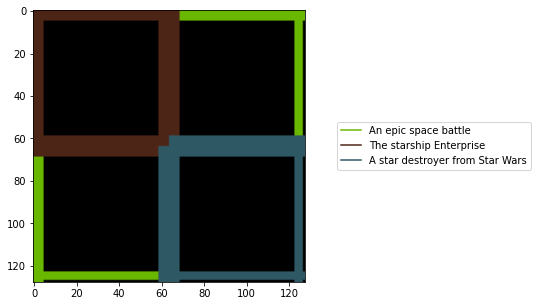

In [ ]:
import matplotlib.pyplot as plt

guidance_mag = 20.0

# Specify the locations of textual descriptions to compose
# The keys have the form (scale, x, y) where scale is the size of the canvas and x, y is the starting locations

context = {
    (2, 0, 0):{'string':'An epic space battle', 'magnitude':guidance_mag},
    (1, 0, 0):{'string':'The starship Enterprise', 'magnitude':guidance_mag},
    (1, 64, 64):{'string':'A star destroyer from Star Wars', 'magnitude':guidance_mag},
}

# context = {
#     (2, 0, 0):{'string':'A fantasy landscape, wallpaper, concept art, extremely detailed', 'magnitude':guidance_mag},
#     (1, 60, 60):{'string':'a blue lake, fantasy, wallpaper, extremely detailed', 'magnitude':guidance_mag},
#     (1, 20, 20):{'string':'A fancy castle, fantasy, wallpaper, extremely detailed', 'magnitude':guidance_mag},
# }



color_lookup = {}
np.random.seed(1)
for k, v in context.items():
  color_lookup[v['string']] = (np.random.uniform(size=(3,)), k[0]**2)

plt.figure(figsize=(5,5))
img = visualize_context(128, 64, context, color_lookup)

plt.imshow(img)

for k, v in context.items():
    scale, xstart, ystart = k
    caption = v['string']
    color = color_lookup[caption][0]
    plt.plot([],[],color=color,label=caption)


plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

plt.savefig('composite_captions.pdf', bbox_inches='tight')
plt.savefig('composite_captions.png', bbox_inches='tight', facecolor=plt.gca().get_facecolor())
# %download_file composite_captions.pdf
# %download_file composite_captions.png

In [ ]:
import torch

from PIL import Image
from torch import autocast

has_cuda = torch.cuda.is_available()
device = torch.device('cpu' if not has_cuda else 'cuda')
print(device)

# initialize stable diffusion model
pipe = TapistryStableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-base",
    use_auth_token=True
).to(device)

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

cuda


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [ ]:
num_steps = 1000

# increase the number of Langevin MCMC steps run to sample between intermediate distributions
# more steps improves sampling quality
la_steps = 10

la_step_sizes = pipe.scheduler.betas * 2

alphas = 1 - pipe.scheduler.betas
alphas_cumprod = np.cumprod(alphas)
scalar = np.sqrt(1 / (1 - alphas_cumprod))

la_sampler = AnnealedULASampler(num_steps, la_steps, la_step_sizes, None, None, None)

In [ ]:
import torch as th
from IPython.display import display

seed = 34
# Number of intermediate transition distributions to specify
steps = 100

generator = th.Generator('cuda').manual_seed(seed)


latents = pipe(context, la_sampler, height=1024, width=1024, generator=generator,
              num_inference_steps=steps)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
def decode_grid_redundant(latents, pipe):
  _, _, H, W = latents.size()
  im = np.zeros((H*8, W*8, 3))
  im_count = np.zeros((H*8, W*8))

  height_chunk = H // 32 - 1
  width_chunk = W // 32 - 1


  for hix in range(height_chunk):
    for wix in range(width_chunk):
      hstart = hix * 32
      wstart = wix * 32
      hstart_im = hix * 256
      wstart_im = wix * 256

      latent = latents[:, :, hstart:hstart+64, wstart:wstart+64]
      im_patch = pipe.decode_latents(latent.detach())

      im[hstart_im:hstart_im+512, wstart_im:wstart_im+512] = im_patch + im[hstart_im:hstart_im+512, wstart_im:wstart_im+512]
      im_count[hstart_im:hstart_im+512, wstart_im:wstart_im+512] = 1 +  im_count[hstart_im:hstart_im+512, wstart_im:wstart_im+512]

  im = im / im_count[:, :, None]

  return im

In [ ]:
# use the line below to decode latents to images

with torch.no_grad():
  image = decode_grid_redundant(latents, pipe)

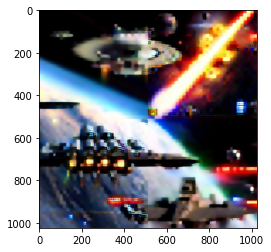

In [ ]:
import matplotlib.pyplot as plt
from imageio import imwrite

imwrite("test.png", image)
plt.imshow(image)